In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from PIL import Image, ImageChops
import matplotlib.image as mpimg
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec

from scipy.io import savemat, loadmat

import os

from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, AutoMinorLocator

dc = plt.rcParams['axes.prop_cycle'].by_key()['color']

# constant and device parameters

In [16]:
# --- Constants ---
hbar = 1.055e-34      # Planck's constant [J·s]
kB = 1.381e-23        # Boltzmann constant [J/K]
om_a = 2 * np.pi * 1.0e9
om_b = 2 * np.pi * 9.0e9
kappa_a = 2 * np.pi * 1.0e3
kappa_b = 2 * np.pi * 1.0e3
lamb = 2 * np.pi * 50e3  # Cross-Kerr coupling [Hz]
alpha = 1        # Coherent amplitude
N_shots = 1e4

# CM envelope, QFI, and sensitivity

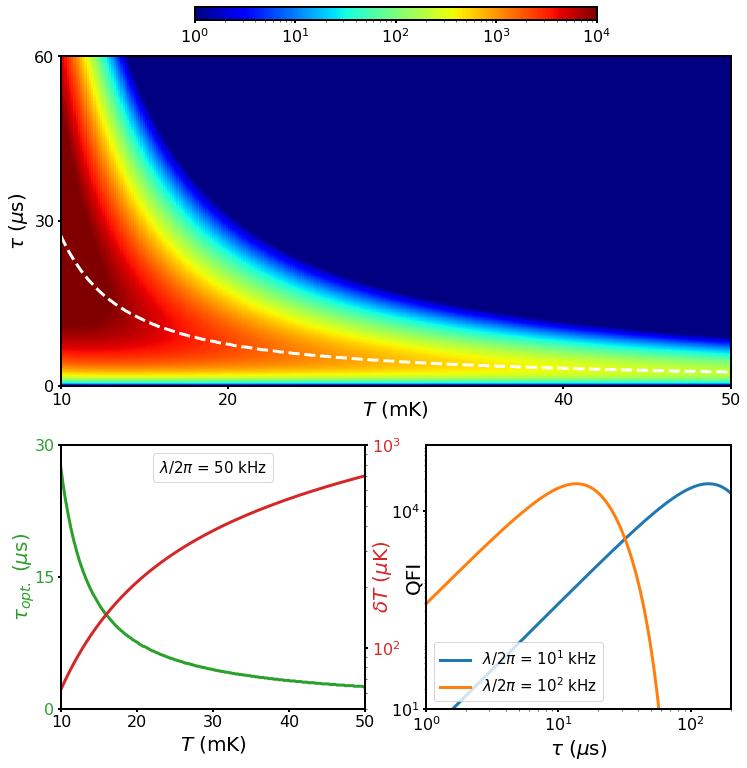

In [ ]:
def n_th(om, T):
    return 1.0 / (np.exp(hbar*om/(kB*T)) - 1.0)
def dndT(om, T):
    nbar = n_th(om, T)
    return (hbar*om/(kB*T**2)) * nbar * (1.0 + nbar)

def Gamma(om, T, lam, tau):
    nbar = n_th(om, T)
    return 0.5*(lam*tau)**2 * nbar * (1+nbar)
def dGdT(om, T, lam, tau):
    nbar = n_th(om, T)
    return 0.5*(lam*tau)**2 * (1+2*nbar) * dndT(om, T)

def C(om, T, lam, tau):
    return np.exp(-2*alpha**2 * (1.0 - np.exp(-Gamma(om, T, lam, tau))))
def dCdT(om, T, lam, tau):
    C_cm = C(om, T, lam, tau)
    return  2*alpha**2 * np.exp(-Gamma(om, T, lam, tau)) * dGdT(om, T, lam, tau) * C_cm

def qfi_cm(om, T, lam, tau):
    nume = dCdT(om, T, lam, tau)**2
    denom = 1 - C(om, T, lam, tau)**2
    return nume / (denom + 1e-300)

T_vals = np.linspace(0.01, 0.05, 300)        
tau_vals = np.linspace(1e-8, 200e-6, 3000)     
T_grid, tau_grid = np.meshgrid(T_vals, tau_vals)

FQ_grid = qfi_cm(om_a, T_grid, lamb, tau_grid)

n_shots = [] 
optimal_tau = []
optimal_FQ = []
T_sen = []

for T in T_vals:
    QFI_array = qfi_cm(om_a, T, lamb, tau_vals)
    idx_max = np.argmax(QFI_array)
    tau_opt = tau_vals[idx_max]
    FQ_max = QFI_array[idx_max]
    
    optimal_tau.append(tau_opt* 1e6)
    optimal_FQ.append(FQ_max)
    n_shots.append(1/tau_opt)
    T_sen.append(1 / np.sqrt(N_shots * FQ_max) if FQ_max > 0 else np.inf)

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(2, 2, figure=fig, height_ratios=[1.0,0.8])

ax0 = fig.add_subplot(gs[0, :])
pcm = ax0.pcolormesh(T_vals * 1e3, tau_vals * 1e6, FQ_grid, shading='auto', cmap='jet', norm=LogNorm(vmin=1e0, vmax=1e4))

ax0.plot(T_vals * 1e3, optimal_tau, 'w--', linewidth=3, label='Optimal $\\tau$')  # example line

cax = inset_axes(ax0, width="60%", height="40%", loc='upper center', bbox_to_anchor=(0, 1.05, 1.0, 0.1), 
                 bbox_transform=ax0.transAxes, borderpad=0)
cb = fig.colorbar(pcm, cax=cax, orientation='horizontal')
ax0.set_xlim(10, 50)
ax0.set_xticks([10, 20, 40, 50])
ax0.set_xlabel('$T$ (mK)', fontsize=20)
ax0.xaxis.set_label_coords(0.5, -0.04)
ax0.set_ylim(0, 60)
ax0.set_yticks([0, 30, 60])
ax0.set_ylabel('$\\tau$ ($\\mu$s)', fontsize=20)

ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(T_vals*1e3, np.array(optimal_tau), color=dc[2], lw=3, label="$\\lambda / 2\pi$ = 50 kHz")
ax1.set_xlabel('$T$ (mK)', fontsize=20)
ax1.set_ylabel('$\\tau_{opt.}$ ($\\mu$s)', color=dc[2], fontsize=20)
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax1.tick_params(axis='y', labelcolor=dc[2])
ax1.set_ylim(0, 30)
ax1.set_yticks([0, 15, 30])
# ax1.legend(fontsize=15)
plt.legend(handlelength=0, handletextpad=0, fontsize=15, loc="upper center")

ax11 = ax1.twinx()
ax11.plot(T_vals * 1e3, np.array(T_sen) * 1e6, color=dc[3], lw=3, label='Sensitivity $\\delta T$')
ax11.set_xlim(10, 50)
ax11.set_ylim(50, 1000)
ax11.set_ylabel('$\\delta T$ ($\\mu$K)', color=dc[3], fontsize=20)
ax11.yaxis.set_label_coords(1.02, 0.5)
ax11.set_yscale('log')
ax11.tick_params(axis='y', labelcolor=dc[3])

# Plot QFI at 10 mK
lam_list = [10e3, 100e3]
T0 = 0.01
ax2 = fig.add_subplot(gs[1, 1])
for lam in lam_list:
    exponent = np.log10(lam / 1e3)
    exponent_rounded = int(round(exponent))
    ax2.semilogy(tau_vals * 1e6, qfi_cm(om_a, T0, 2*np.pi*lam, tau_vals), lw=3, 
                 label=f"$\\lambda / 2\pi$ = $10^{{{exponent_rounded}}}$ kHz")
ax2.set_xlabel('$\\tau$ ($\\mu$s)', fontsize=20)
ax2.set_xlim(1, 200)
ax2.set_xscale('log')
ax2.set_ylabel('QFI', fontsize=20)
ax2.set_ylim(10, 1e5)
ax2.set_yticks([1e1, 1e4])
ax2.yaxis.set_label_coords(-0.01, 0.5)
ax2.legend(fontsize=15)

labels = ['(a)', '(b)'] 
line_width = 2.0  # Desired line thickness (adjust as needed)
for i, ax in enumerate(fig.get_axes()): # Iterate through all Axes objects in the figure
    for spine in ax.spines.values():
        spine.set_linewidth(line_width)
    ax.tick_params(width=line_width)
#     ax.text(0.02, 0.98, labels[i], transform=ax.transAxes,
#             fontsize=30, fontweight='normal', va='top', ha='left')
    
    ax.tick_params(axis='both',  direction='out', labelsize=16, length=3.0)
    for tick_label in ax.get_xticklabels():
        tick_label.set_fontweight('normal')
    for tick_label in ax.get_yticklabels():
        tick_label.set_fontweight('normal')

plt.show()

# phase-shift QFI and sensitivity

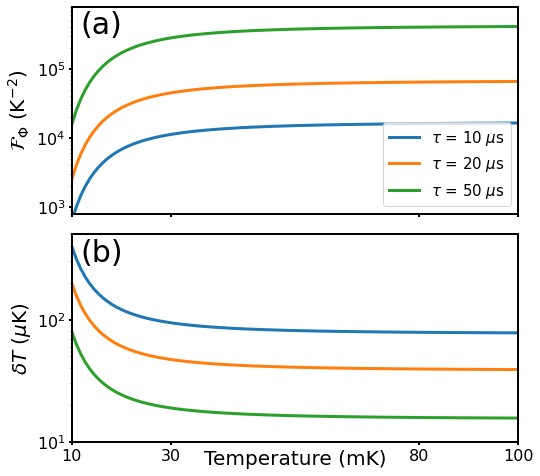

In [ ]:
eta = 1.0  # heterodyne measurement efficiency in quantum limit = 0.5

def qfi_phase(om, T, lam, tau):
    return eta*4*alpha**2 * (lam * tau * dndT(om, T))**2

T_vals = np.linspace(0.01, 0.1, 101)
tau_vals = [10, 20, 50]

fig, ax = plt.subplots(2,1, figsize=(8, 8), sharex=True, gridspec_kw={'wspace': 0.15, 'hspace': 0.1})
for tau in tau_vals:
    exponent = np.log10(tau)
    exponent_rounded = int(round(exponent))
    ax[0].semilogy(1e3*T_vals, qfi_phase(om_a, T_vals, lamb, tau*1e-6), lw = 3, label=f"$\\tau$ = {tau} $\\mu$s")
    ax[1].semilogy(1e3*T_vals, 1e6/np.sqrt(N_shots * qfi_phase(om_a, T_vals, lamb, tau*1e-6)), lw = 3)
ax[0].legend(loc='lower right', fontsize=15)
ax[0].set_ylim(8e2, 8e5)
ax[0].set_ylabel('$\mathcal{F}_{\Phi}$ (K$^{-2}$)', fontsize=20)

ax[1].set_xlim(10, 100)
ax[1].set_xticks([10, 30, 80, 100])
ax[1].set_ylim(10, 500)
ax[1].set_xlabel('Temperature (mK)', fontsize=20)
ax[1].set_ylabel('$\\delta T$ ($\\mu$K)', fontsize=20)
ax[1].xaxis.set_label_coords(0.5, -0.04)

labels = ['(a)', '(b)'] 
line_width = 2.0  # Desired line thickness (adjust as needed)
for i, ax in enumerate(fig.get_axes()): # Iterate through all Axes objects in the figure
    for spine in ax.spines.values():
        spine.set_linewidth(line_width)
    ax.tick_params(width=line_width)
    ax.text(0.02, 0.98, labels[i], transform=ax.transAxes,
            fontsize=30, fontweight='normal', va='top', ha='left')
    
    ax.tick_params(axis='both',  direction='out', labelsize=16, length=3.0)
    for tick_label in ax.get_xticklabels():
        tick_label.set_fontweight('normal')
    for tick_label in ax.get_yticklabels():
        tick_label.set_fontweight('normal')

# qubit-only QFI and sensitivity

<ipython-input-6-4ab252a493d6>:24: RuntimeWarning: overflow encountered in exp
  term_deph = (dGdT**2) / (np.exp(2*Gamma) - 1.0 + 1e-300)


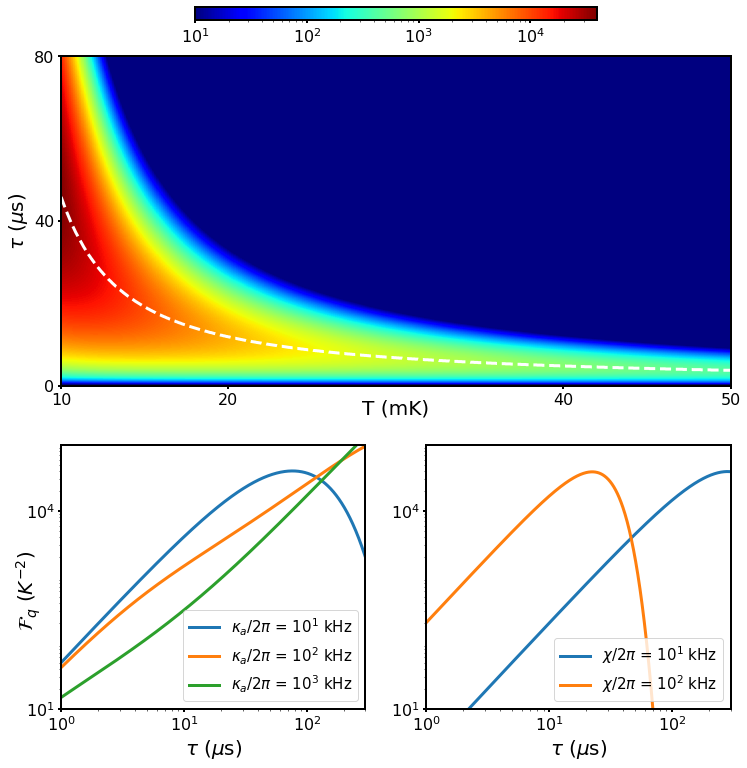

In [ ]:
def f_kappa(tau, kappa):
    return tau/kappa - (1.0 - np.exp(-kappa*tau)) / (kappa**2)

def Gamma_q(om, T, chi, tau, kappa):
    nbar = n_th(om, T)
    fk = f_kappa(tau, kappa)
    return chi**2 * nbar*(1.0 + nbar) * fk

def phi_q(om, T, chi, tau):
    nbar = n_th(om, T)
    return chi*nbar*tau

def C_q(om, T, chi, tau, kappa):
    phi = phi_q(om, T, chi, tau)
    Gamma = Gamma_q(om, T, chi, tau, kappa)
    return np.exp(-j*phi) * np.exp(-Gamma)

def qfi_qubit(om, T, tau, chi, kappa):
    nbar = n_th(om, T)
    fk = f_kappa(tau, kappa)
    Gamma = Gamma_q(om, T, chi, tau, kappa)
    dGdT = chi**2 * fk * (1.0 + 2.0*nbar) * dndT(om, T)
    dpdT = chi*tau * dndT(om, T)
    term_deph = (dGdT**2) / (np.exp(2*Gamma) - 1.0 + 1e-300)
    term_phase = np.exp(-2*Gamma) * (dpdT**2)
    return term_deph + term_phase

T0 = 0.01
chi_a = 50e3

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(2, 2, figure=fig, height_ratios=[1.0, 0.8])

T_vals = np.linspace(0.01, 0.05, 1001)         
tau_vals = np.linspace(1e-8, 100e-6, 2001)  
T_grid, tau_grid = np.meshgrid(T_vals, tau_vals)
FQ_grid = qfi_qubit(om_a, T_grid, tau_grid, 2*np.pi*chi_a, 2*np.pi*1e3)

optimal_tau = []
optimal_FQ = []
for T in T_vals:
    QFI_array = qfi_qubit(om_a, T, tau_vals, 2*np.pi*chi_a, 2*np.pi*1e3)
    tau_opt = tau_vals[np.argmax(QFI_array)]
    FQ_max = QFI_array[idx_max]
    
    optimal_tau.append(tau_opt* 1e6)
    optimal_FQ.append(FQ_max)


ax0 = fig.add_subplot(gs[0, :])
pcm = ax0.pcolormesh(T_vals*1e3, tau_vals*1e6, FQ_grid, shading='auto', cmap='jet', norm=LogNorm(vmin=10))
cax = inset_axes(ax0, width="60%", height="40%", loc='upper center', 
                 bbox_to_anchor=(0, 1.05, 1.0, 0.1), bbox_transform=ax0.transAxes, borderpad=0)
cb = fig.colorbar(pcm, cax=cax, orientation='horizontal')
ax0.plot(1e3*T_vals, optimal_tau, 'w--', lw=3)
ax0.set_xlim(10, 50)
ax0.set_xticks([10, 20, 40, 50])
ax0.set_xlabel("T (mK)", fontsize=20)
ax0.xaxis.set_label_coords(0.5, -0.04)
ax0.set_ylim(0, 80)
ax0.set_yticks([0, 40, 80])
ax0.set_ylabel("$\\tau$ ($\mu$s)", fontsize=20)

taus = 1e-6*np.geomspace(1, 300, 1001)
kappa_list = [10e3, 100e3, 1000e3]
ax1 = fig.add_subplot(gs[1, 0])
for kappa in kappa_list:
    exponent = np.log10(kappa / 1e3)
    exponent_rounded = int(round(exponent))
    ax1.loglog(1e6*taus, qfi_qubit(om_a, T0, taus, 2*np.pi*chi_a, 2*np.pi*kappa), lw=3, 
                 label=f"$\\kappa_a / 2\pi$ = $10^{{{exponent_rounded}}}$ kHz")
ax1.set_xlim(1, 300)
ax1.set_xlabel("$\\tau$ ($\\mu$s)", fontsize=20)
ax1.set_ylim(10, 1e5)
ax1.set_yticks([1e1, 1e4])
ax1.set_ylabel("$\\mathcal{F}_q$ ($K^{-2}$)", fontsize=20)
ax1.yaxis.set_label_coords(-0.06, 0.45)
ax1.legend(loc='lower right', fontsize=15)

kappa = 2*np.pi*1e3
taus = 1e-6*np.geomspace(1, 300, 1001)
chi_list = [10e3, 100e3]
ax2 = fig.add_subplot(gs[1, 1])
for chi in chi_list:
    exponent = np.log10(chi / 1e3)
    exponent_rounded = int(round(exponent))
    ax2.loglog(1e6*taus, qfi_qubit(om_a, T0, taus, 2*np.pi*chi, kappa), lw=3, 
                 label=f"$\\chi / 2\pi$ = $10^{{{exponent_rounded}}}$ kHz")
ax2.set_xlim(1, 300)
ax2.set_ylim(10, 1e5)
ax2.set_yticks([1e1, 1e4])
ax2.set_xlabel("$\\tau$ ($\\mu$s)", fontsize=20)
ax2.legend(loc='lower right', fontsize=15)

labels = ['(a)', '(b)'] 
line_width = 2.0  # Desired line thickness (adjust as needed)
for i, ax in enumerate(fig.get_axes()): # Iterate through all Axes objects in the figure
    for spine in ax.spines.values():
        spine.set_linewidth(line_width)
    ax.tick_params(width=line_width)
#     ax.text(0.02, 0.98, labels[i], transform=ax.transAxes,
#             fontsize=30, fontweight='normal', va='top', ha='left')
    
    ax.tick_params(axis='both',  direction='out', labelsize=16, length=3.0)
    for tick_label in ax.get_xticklabels():
        tick_label.set_fontweight('normal')
    for tick_label in ax.get_yticklabels():
        tick_label.set_fontweight('normal')

# compare CM, Phase-shift, and Qubit-only

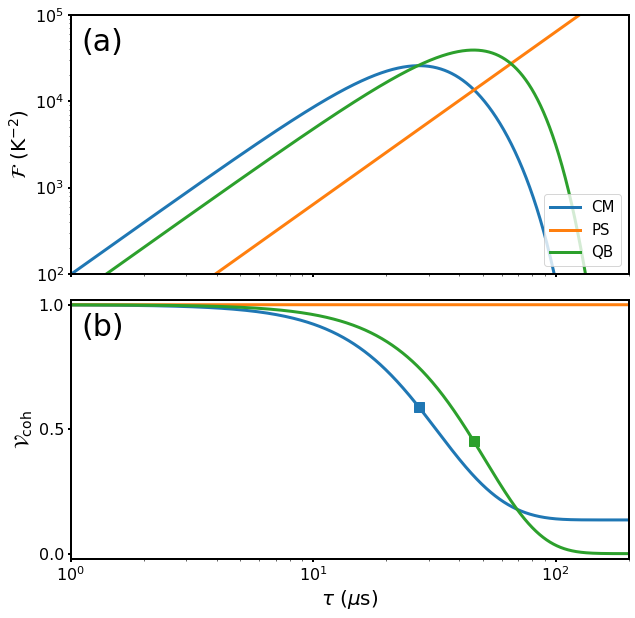

In [ ]:
T0 = 0.01
kappa_a = 2*np.pi*1e3
lamb = 50e3
taus = 1e-6 * np.linspace(1, 200, 2001)

fig, ax = plt.subplots(2,1, figsize=(10, 10), sharex=True, gridspec_kw={'wspace': 0.2, 'hspace': 0.1})

QFI_cm = qfi_cm(om_a, T0, 2*np.pi*lamb, taus)
tau0_cm = taus[np.argmax(QFI_cm)]
QFI0_cm = np.max(QFI_cm)
QFI_phase = qfi_phase(om_a, T0, 2*np.pi*lamb, taus)
QFI_qubit = qfi_qubit(om_a, T0, taus, 2*np.pi*lamb, kappa_a)
tau0_qb = taus[np.argmax(QFI_qubit)]

ax[0].loglog(1e6*taus, QFI_cm,    lw=3, color=dc[0], label='CM')
ax[0].loglog(1e6*taus, QFI_phase, lw=3, color=dc[1], label='PS')
ax[0].loglog(1e6*taus, QFI_qubit, lw=3, color=dc[2], label='QB')
ax[0].set_xlim(1, 200)
ax[0].set_ylim(1e2, 1e5)
ax[0].set_ylabel(r'$\mathcal{F}$ (K$^{-2}$)', fontsize=20)
ax[0].legend(fontsize=15, loc="lower right")


alpha = 1.0
def vis_cm(om, tau, lam, T):
    nbar = n_th(om, T)
    Gamma_phi = 0.5*(lam*tau)**2 * nbar*(1+nbar)
    C = np.exp(-2*alpha**2*(1.0 - np.exp(-Gamma_phi)))
    return C

def vis_phase(vars):
    return np.ones_like(vars)

def vis_qubit(om, tau, kappa, chi, T):
    nbar = n_th(om, T)
    Gamma_q = chi**2 * nbar*(1.0 + nbar) * f_kappa(tau, kappa)
    return np.exp(-Gamma_q)

C_cm    = vis_cm(om_a, taus, 2*np.pi*lamb, T0)
C0_cm = vis_cm(om_a, tau0_cm, 2*np.pi*lamb, T0)
C_phase = vis_phase(taus)
C_qubit = vis_qubit(om_a, taus, kappa_a, 2*np.pi*lamb, T0)
C0_qubit = vis_qubit(om_a, tau0_qb, kappa_a, 2*np.pi*lamb, T0)
ax[1].semilogx(1e6*taus, C_cm,    lw=3, color=dc[0])
ax[1].semilogx(1e6*tau0_cm, C0_cm, marker='s', markersize=10)
ax[1].semilogx(1e6*taus, C_phase, lw=3, color=dc[1])
ax[1].semilogx(1e6*taus, C_qubit, lw=3, color=dc[2])
ax[1].semilogx(1e6*tau0_qb, C0_qubit, color=dc[2], marker='s', markersize=10)
ax[1].set_xlabel(r'$\tau$ ($\mu$s)', fontsize=20)
ax[1].set_ylabel(r'$\mathcal{V}_{\mathrm{coh}}$', fontsize=20)
ax[1].set_ylim(-0.02, 1.02)
ax[1].set_yticks([0.0, 0.5, 1.0])

labels = ['(a)', '(b)'] 
line_width = 2.0  # Desired line thickness (adjust as needed)
for i, ax in enumerate(fig.get_axes()): # Iterate through all Axes objects in the figure
    for spine in ax.spines.values():
        spine.set_linewidth(line_width)
    ax.tick_params(width=line_width)
    ax.text(0.02, 0.95, labels[i], transform=ax.transAxes,
            fontsize=30, fontweight='normal', va='top', ha='left')
    
    ax.tick_params(axis='both',  direction='out', labelsize=16, length=3.0)
    for tick_label in ax.get_xticklabels():
        tick_label.set_fontweight('normal')
    for tick_label in ax.get_yticklabels():
        tick_label.set_fontweight('normal')
        
plt.show()

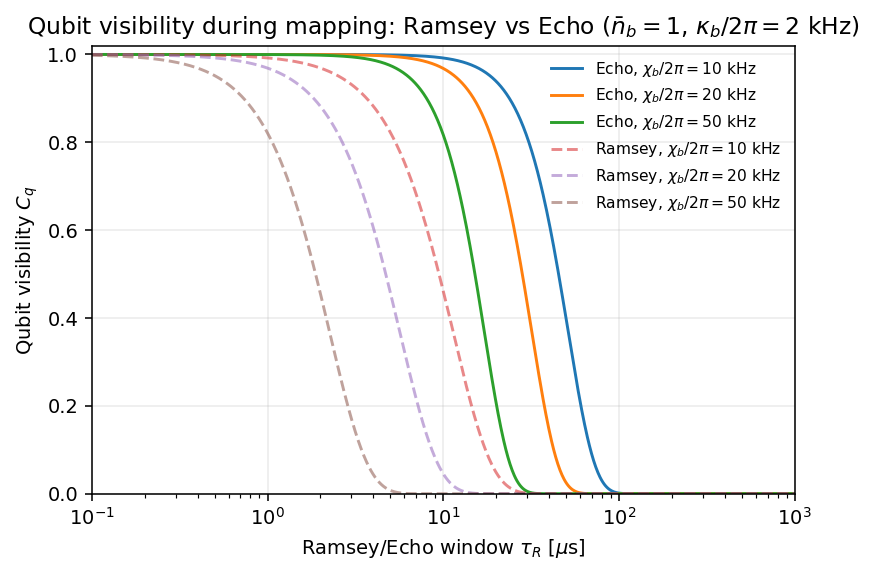

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def chi_from_khz(chi_khz):
    return 2*np.pi*chi_khz*1e3

def kappa_from_khz(kappa_khz):
    return 2*np.pi*kappa_khz*1e3

def Cq_ramsey(t, chi, var_n, kappa):
    bracket = (kappa*t - 1.0 + np.exp(-kappa*t)) / (kappa**2 + 0.0)
    return np.exp(-4.0 * (chi**2) * var_n * bracket)

def Cq_echo(t, chi, var_n, kappa):
    bracket = (kappa*t - 3.0 + 4.0*np.exp(-kappa*t/2.0) - np.exp(-kappa*t)) / (kappa**2 + 0.0)
    return np.exp(-4.0 * (chi**2) * var_n * bracket)

nbar = 1.0                       # coherent probe photons during mapping
var_nb = nbar                    # number variance for a coherent state
kappa_b_khz = 1.0                # probe linewidth kappa_b/2pi [kHz]
kappa_b = kappa_from_khz(kappa_b_khz)

chi_list_khz = [10.0, 20.0, 50.0]
chi_list = [chi_from_khz(x) for x in chi_list_khz]

t_us = np.geomspace(0.1, 1000, 1001)
t = t_us*1e-6

vis_echo = {ck: Cq_echo(t, chi_from_khz(ck), var_nb, kappa_b) for ck in chi_list_khz}
vis_ramsey = {ck: Cq_ramsey(t, chi_from_khz(ck), var_nb, kappa_b) for ck in chi_list_khz}

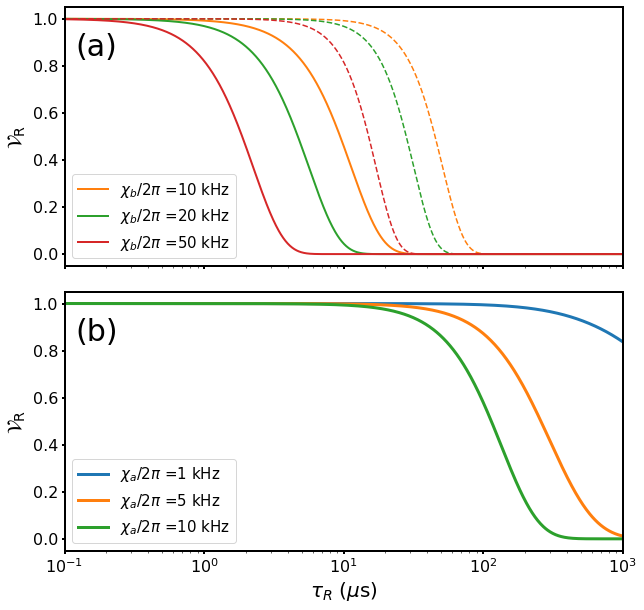

In [ ]:
def Cq_ramsey(t, om, chi, alpha, kappa, T):
   
    t = np.asarray(t, dtype=float)
    nbar = n_th(om, T)
    var_n = (abs(alpha)**2) + nbar*(1.0 + nbar)
    bracket = (t / kappa) - (1.0 - np.exp(-kappa * t)) / (kappa**2)
    expo = -4.0 * (chi**2) * var_n * bracket
    return np.exp(expo)

taus = np.geomspace(1e-6*0.1, 1e-6*1000, 1001)

T0 = 0.01
alpha = 1
om_b = 2*np.pi*9e9        
kappa_b = 2*np.pi*1e3    
# chi_b_list = [5e3, 10e3, 20e3]
chi_b_list = [10e3, 20e3, 50e3]

fig, ax = plt.subplots(2,1, figsize=(10, 10), sharex=True, gridspec_kw={'wspace': 0.2, 'hspace': 0.1})
i = 0
for chi_b in chi_b_list:
    i = i + 1
    C = Cq_ramsey(taus, om_b, 2*np.pi*chi_b, alpha, kappa_b, T0)
    ax[0].semilogx(taus*1e6, C, lw=2, color=dc[i], label=f"$\\chi_b / 2\pi$ ={chi_b/1e3:.0f} kHz")
    vis_echo = Cq_echo(taus, 2*np.pi*chi_b, alpha**2, kappa_b)
    ax[0].semilogx(taus*1e6, vis_echo, '--', color=dc[i], )
ax[0].set_ylabel(r"$\mathcal{V}_{\mathrm{R}}$", fontsize=20)
ax[0].legend(fontsize=15, loc="lower left")

alpha = 0
om_a = 2 * np.pi* 1e9        
kappa_a = 2*np.pi*1e3  
# chi_a_list = [10e3, 20e3, 50e3]
chi_a_list = [1e3, 5e3, 10e3]

for chi_a in chi_a_list:
    C = Cq_ramsey(taus, om_a, 2*np.pi*chi_a, alpha, kappa_a, T0)
    ax[1].semilogx(taus*1e6, C, lw=3, label=f"$\\chi_a / 2\pi$ ={chi_a/1e3:.0f} kHz")
ax[1].set_xlim(0.1, 1000)
ax[1].set_xlabel("$\\tau_R$ ($\\mu$s)", fontsize=20)
ax[1].set_ylabel(r"$\mathcal{V}_{\mathrm{R}}$", fontsize=20)
ax[1].legend(fontsize=15)


labels = ['(a)', '(b)'] 
line_width = 2.0  # Desired line thickness (adjust as needed)
for i, ax in enumerate(fig.get_axes()): # Iterate through all Axes objects in the figure
    for spine in ax.spines.values():
        spine.set_linewidth(line_width)
    ax.tick_params(width=line_width)
    ax.text(0.02, 0.9, labels[i], transform=ax.transAxes,
            fontsize=30, fontweight='normal', va='top', ha='left')
    
    ax.tick_params(axis='both',  direction='out', labelsize=16, length=3.0)
    for tick_label in ax.get_xticklabels():
        tick_label.set_fontweight('normal')
    for tick_label in ax.get_yticklabels():
        tick_label.set_fontweight('normal')
        
plt.show()

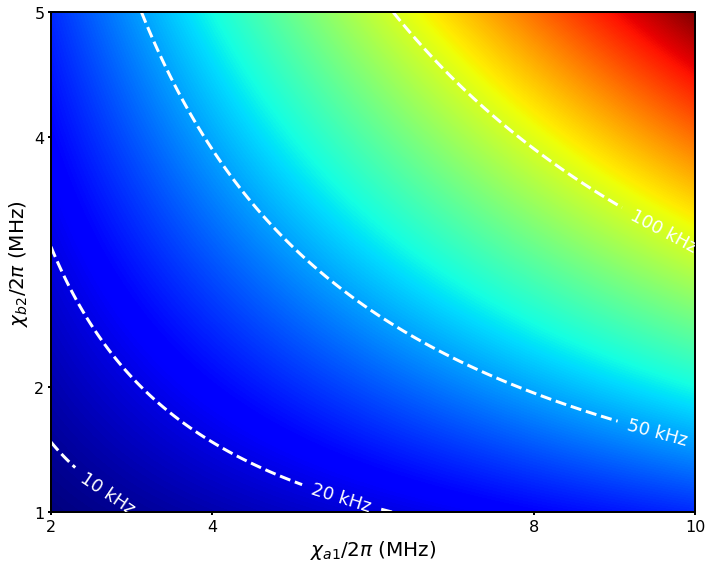

In [ ]:
chi_a1_min_MHz, chi_a1_max_MHz = 2.0, 10.0
chi_b2_min_MHz, chi_b2_max_MHz = 1.0, 5.0
N = 800

rho = 0.20 # rho = J_XY / Delta_12
Delta12_over_2pi_MHz = 100.0 # Δ_12 / 2π (MHz)

contours_kHz = [10, 20, 50, 100]

# ---------- Grid ----------
Xa_MHz = np.linspace(chi_a1_min_MHz, chi_a1_max_MHz, N)
Xb_MHz = np.linspace(chi_b2_min_MHz, chi_b2_max_MHz, N)
Xa, Xb = np.meshgrid(Xa_MHz, Xb_MHz, indexing="xy")

MHz = 1e6
kHz = 1e3

chi_a1_Hz = Xa * MHz * 2*np.pi    # χ_a1 (rad/s)
chi_b2_Hz = Xb * MHz * 2*np.pi    # χ_b2 (rad/s)
Delta12_Hz = Delta12_over_2pi_MHz * MHz * 2*np.pi

lambda_Hz = 8.0 * chi_a1_Hz * chi_b2_Hz * rho**2 / Delta12_Hz
lambda_over_2pi_kHz = (lambda_Hz / (2*np.pi)) / kHz

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(10, 8))

extent = [chi_a1_min_MHz, chi_a1_max_MHz, chi_b2_min_MHz, chi_b2_max_MHz]
im = ax.imshow(lambda_over_2pi_kHz, origin="lower", cmap="jet",extent=extent, aspect="auto")

CS = plt.contour(
    Xa, Xb, lambda_over_2pi_kHz,
    levels=contours_kHz,
    colors="white",
    linestyles="dashed",
    linewidths=3.0
)
clabels = plt.clabel(CS, inline=True, fontsize=18, fmt="%.0f kHz", colors="white")        

ax.set_xlabel(r"$\chi_{a1}/2\pi$ (MHz)", fontsize=20)
ax.set_ylabel(r"$\chi_{b2}/2\pi$ (MHz)", fontsize=20)
ax.set_xlim(chi_a1_min_MHz, chi_a1_max_MHz)
ax.set_xticks([2, 4, 8, 10])
ax.set_ylim(chi_b2_min_MHz, chi_b2_max_MHz)
ax.set_yticks([1, 2, 4, 5])

labels = ['(a)', '(b)'] 
line_width = 2.0  # Desired line thickness (adjust as needed)
for i, ax in enumerate(fig.get_axes()): # Iterate through all Axes objects in the figure
    for spine in ax.spines.values():
        spine.set_linewidth(line_width)
    ax.tick_params(width=line_width)
#     ax.text(0.02, 0.9, labels[i], transform=ax.transAxes,
#             fontsize=30, fontweight='normal', va='top', ha='left')
    
    ax.tick_params(axis='both',  direction='out', labelsize=16, length=3.0)
    for tick_label in ax.get_xticklabels():
        tick_label.set_fontweight('normal')
    for tick_label in ax.get_yticklabels():
        tick_label.set_fontweight('normal')
        
plt.tight_layout()
plt.show()